### **Download Resources and Model**

In [1]:
!pip install -qq ftfy regex tqdm
!pip install -qq transformers
!pip install wandb -qU
!pip install -qq evaluate
!pip install -qq pytorch-lightning==1.9.0
!pip install -qq torchmetrics

In [2]:
# Log in to Wandb account
# Code to prevent wandb from crashing Colab
import wandb
import sys

def wandb_colab_login():
  sys.modules["google.colab2"] = sys.modules["google.colab"]
  del sys.modules["google.colab"]
  wandb.login(key="<YOUR_API_KEY>")
  sys.modules["google.colab"] = sys.modules["google.colab2"]


wandb_colab_login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from PIL import Image
from transformers import AdamW, get_linear_schedule_with_warmup

In [4]:
%matplotlib inline

import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import os

**Define Base Models**

In [5]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt_model = GPT2LMHeadModel.from_pretrained('gpt2')


# GPT-2 tokenizer don't have defined pad_token
tokenizer.pad_token = tokenizer.eos_token

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [6]:
from transformers import ConvNextModel, ConvNextFeatureExtractor

convNext_model = ConvNextModel.from_pretrained("facebook/convnext-base-224-22k-1k")

image_processor = ConvNextFeatureExtractor.from_pretrained("facebook/convnext-base-224-22k-1k")

config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/354M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(


### **Amazon Dataset**

Download CSV and images

In [7]:
!wget -q -O images.zip https://comp576-image-data.s3.us-east-2.amazonaws.com/image.zip
!unzip -qq images.zip

In [8]:
!wget -q -O text.csv https://raw.githubusercontent.com/littlehongman/Comp576-Group41-Image-Captioning/main/Amazon_cleaned.csv

In [9]:
import torchtext
import pandas as pd
import random
from torch.utils.data.dataset import Dataset
from torch.nn.utils.rnn import pad_sequence


random.seed(42)

class AmazonDataset(Dataset):
    def __init__(self, tokenizer,
                 split: str, # train, val
                 max_length: int,
                 df, # Pandas dataframe
                 text_type,
                 image_dir = "/content/image",
                 image_transform = None):

        assert split in ['val', 'train'], 'invalid split'
        assert text_type in ['product_name', 'review_content'], 'invalid split'

        self.tokenizer = tokenizer
        self.image_transform = image_transform
        self.split = split
        self.max_length = max_length
        self.image_dir = image_dir


        # Get list of indices of (img, caption) pair
        # self.indices = df['index'].tolist()

        self.indices = df['index'].tolist()


        # Tokenize and add examples to the local variables.
        self.tokenized_texts = list()
        self.images = list()

        for idx, img_idx in enumerate(self.indices):
            # Load and tokenize text
            text = df.iloc[idx][text_type]

            encoded_text = self.tokenizer.encode_plus(
                text, add_special_tokens = True, truncation = True,
                max_length = max_length, padding = 'max_length',
                return_attention_mask = True, return_tensors = 'pt')

            self.tokenized_texts.append(encoded_text)

            # Save image filename
            self.images.append(f"{img_idx}.jpg")


    def __len__(self):
        return len(self.tokenized_texts)

    def __getitem__(self, i):
        text = self.tokenized_texts[i]['input_ids'][0]
        text_mask = self.tokenized_texts[i]['attention_mask'][0]

        # Load the image
        image = Image.open(os.path.join(f"{self.image_dir}/", self.images[i])).convert("RGB")

        if self.image_transform:
            # AutoProcessor transform will return extra dimension
            image = self.image_transform(image, return_tensors="pt").pixel_values[0]

        # Preprend extra mask for the encoder embedding
        image_embedding_mask = torch.ones(self.max_length)
        text_mask = torch.concat((image_embedding_mask, text_mask), -1)

        return image, text, text_mask


**Shuffle the Pandas Dataframe**

In [10]:
text_type = "product_name"
text_dir = "/content/text.csv"


# Read the text csv file using pandas
df = pd.read_csv(text_dir)

# Remove nan
df = df[df[text_type].notna()]

# Random Split
df_train = df.sample(frac=0.9,random_state=200)
df_test = df.drop(df_train.index)

In [11]:
max_length = 20

trainset = AmazonDataset(tokenizer, 'train', max_length, df_train, text_type,
                             image_transform = image_processor)

valset = AmazonDataset(tokenizer, 'val', max_length, df_test, text_type,
                             image_transform = image_processor)

In [12]:
testset = AmazonDataset(tokenizer, 'val', max_length, df_test, text_type,
                             image_transform = None)

In [13]:
import multiprocessing

cores = multiprocessing.cpu_count()

train_loader = torch.utils.data.DataLoader(trainset,
                                           batch_size = 8,
                                           num_workers = cores // 2,
                                           shuffle = True,
                                           pin_memory=False)

val_loader = torch.utils.data.DataLoader(valset,
                                           batch_size = 8,
                                           num_workers = cores // 2,
                                           shuffle = False,
                                          pin_memory=False)

### **Define Model**

#### **Create the ImageEncoder**

In [14]:
class ImageEncoder(nn.Module):
    def __init__(self, base_network):
        super(ImageEncoder, self).__init__()
        self.base_network = base_network
        self.embedding_size = 1024

    def forward(self, images):
        with torch.no_grad():
            x = self.base_network(pixel_values=images).pooler_output
            x = F.normalize(x, dim=-1)
            x = x.float()

        return x

#### **Create the Mapping Network**

In [15]:
class Mapping(nn.Module):
    def __init__(self, encoder_embedding_size, decoder_embedding_size, length=20):
        super(Mapping, self).__init__()

        self.encoder_embedding_size = encoder_embedding_size
        self.decoder_embedding_size = decoder_embedding_size
        self.length = length

        self.fc1 = nn.Linear(encoder_embedding_size, decoder_embedding_size * length)

    def forward(self, x):
        x = self.fc1(x)

        return x.view(-1, self.length, self.decoder_embedding_size)

#### **Create the TextDecoder Network**

In [16]:
class TextDecoder(nn.Module):
    def __init__(self, base_network):
        super(TextDecoder, self).__init__()
        self.base_network = base_network
        self.embedding_size = self.base_network.transformer.wte.weight.shape[1]
        self.vocab_size = self.base_network.transformer.wte.weight.shape[0]

    def forward(self, concat_embedding, mask=None):
        return self.base_network(inputs_embeds=concat_embedding, attention_mask=mask)


    def get_embedding(self, texts):
        return self.base_network.transformer.wte(texts)

#### **Create the ImageCaptioner Network**

In [17]:
from transformers import StoppingCriteria, StoppingCriteriaList

class StoppingCriteriaSub(StoppingCriteria):
    def __init__(self, stops = [], encounters=1):
        super().__init__()
        self.stops = [stop.to("cuda") for stop in stops]

    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor):
        last_token = input_ids[0][-1]
        for stop in self.stops:
            if tokenizer.decode(stop) == tokenizer.decode(last_token):
                return True
        return False

In [18]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from torchmetrics.text.rouge import ROUGEScore
from torchmetrics import BLEUScore
import evaluate

class ImageCaptioner(pl.LightningModule):
    def __init__(self, encoder, decoder, tokenizer, total_steps, temperature=0.9, max_length=20):
        super(ImageCaptioner, self).__init__()

        self.padding_token_id = tokenizer.pad_token_id
        #self.stop_token_id = tokenizer.encode('.')[0]

        # Define networks
        self.encoder = ImageEncoder(encoder)
        self.decoder = TextDecoder(decoder)
        self.mapping_network = Mapping(self.encoder.embedding_size, self.decoder.embedding_size, max_length)

        # Define variables
        self.temperature = temperature
        self.total_steps = total_steps
        self.max_length = max_length
        self.encoder_embedding_size = self.encoder.embedding_size
        self.decoder_embedding_size = self.decoder.embedding_size
        self.decoder_vocab_size = self.decoder.vocab_size

        # Define loss function
        self.criterion = nn.CrossEntropyLoss(ignore_index = self.padding_token_id)

        # Define stopping criteria
        stop_words = [tokenizer.pad_token]
        stop_words_ids = [tokenizer(stop_word, return_tensors='pt', add_special_tokens=False)['input_ids'].squeeze() for stop_word in stop_words]
        self.stopping_criteria = StoppingCriteriaList([StoppingCriteriaSub(stops=stop_words_ids)])

        # Define learning rate
        self.mapping_lr = 1e-3
        self.decoder_lr = 2e-5

        # Metrics Helpers
        self.rouge = ROUGEScore()
        self.meteor = evaluate.load('meteor')
        self.bleu = BLEUScore(n_gram=1)

        self.save_hyperparameters()

    def forward(self, images, texts, masks):
        texts_embedding = self.decoder.get_embedding(texts)
        images_embedding = self.encoder(images)

        images_projection = self.mapping_network(images_embedding).view(-1, self.max_length, self.decoder_embedding_size)
        embedding_concat = torch.cat((images_projection, texts_embedding), dim=1)

        out = self.decoder(embedding_concat, masks)

        return out

    def predict(self, images):
        model.eval()

        with torch.no_grad():
            images_embedding = self.encoder(images)
            images_projection = model.mapping_network(images_embedding).view(-1, self.max_length, self.decoder_embedding_size)

            input_state = images_projection

            output_ids = model.decoder.base_network.generate(inputs_embeds=images_projection,
                                pad_token_id=tokenizer.eos_token_id,
                                max_new_tokens=self.max_length,
                                num_beams=5,
                                temperature=self.temperature,
                                do_sample=True,
                                penalty_alpha=0.7,
                                no_repeat_ngram_size=1,
                                repetition_penalty=1.1)

        return output_ids[:,1:]

    def training_step(self, batch, batch_idx, optimizer_idx):
        images, texts, masks = batch

        outputs = model(images, texts, masks).logits

        loss = self.criterion(outputs[:, self.max_length - 1: -1].reshape(-1, self.decoder_vocab_size), texts.reshape(-1))

        return loss

    def validation_step(self, batch, batch_idx):
        images, texts, masks = batch

        # Get Loss
        outputs = model(images, texts, masks).logits

        loss = self.criterion(outputs[:, self.max_length - 1: -1].reshape(-1, self.decoder_vocab_size), texts.reshape(-1))

        # Get Scores
        output_ids = self.predict(images).cpu().tolist()
        rouge_score, meteor_score, bleu_score = self.calculate_metrics(output_ids, texts)


        # Use this line, to be read at model checkpoint
        self.log('val/val_loss', loss, on_epoch = True)

        return {'val_loss': loss, 'rouge': rouge_score, 'meteor': meteor_score, 'bleu': bleu_score}

    def calculate_metrics(self, preds, texts):
        targets = texts.cpu()

        total_rouge_scores = 0.0
        total_meteor_scores = 0.0
        total_bleu_scores = 0.0

        for pred, target in zip(preds, targets):
            # truncate to the stop token
            try:
                stop_idx = pred.index(self.padding_token_id)
            except:
                stop_idx = len(pred)

            sentence = tokenizer.decode(pred[:stop_idx])
            target = tokenizer.decode(target, skip_special_tokens=True)

            # ROGUE
            rouge_score = self.rouge(sentence, target)
            total_rouge_scores += rouge_score['rougeL_fmeasure']

            # METEOR
            meteor_score = self.meteor.compute(predictions=[sentence], references=[target])
            total_meteor_scores += torch.tensor(meteor_score['meteor'])

            # BLEU
            bleu_score = self.bleu([sentence], [[target]])
            total_bleu_scores += bleu_score

        return total_rouge_scores / len(preds), total_meteor_scores / len(preds), total_bleu_scores / len(preds)


    def training_epoch_end(self, outputs):
        loss_mean = torch.stack([x['loss'] for x in outputs[0]]).mean()

        print('Epoch {} Training loss: {:.2f}'.format(self.current_epoch, loss_mean))

        # Log training loss
        self.log('train/train_loss', loss_mean)


    def validation_epoch_end(self, outputs):
        loss_mean = torch.stack([x['val_loss'] for x in outputs]).mean()
        rouge_mean = torch.stack([x['rouge'] for x in outputs]).mean()
        meteor_mean = torch.stack([x['meteor'] for x in outputs]).mean()
        bleu_mean = torch.stack([x['bleu'] for x in outputs]).mean()

        print('Epoch {} Validation loss: {:.2f}'.format(self.current_epoch, loss_mean))
        print('Epoch {} Rouge score: {:.2f}'.format(self.current_epoch, rouge_mean * 100))
        print('Epoch {} Meteor score: {:.2f}'.format(self.current_epoch, meteor_mean * 100))
        print('Epoch {} Bleu score: {:.2f}'.format(self.current_epoch, bleu_mean * 100))

        # Log validation loss, rogue
        self.log('val/val_loss', loss_mean)
        self.log('val/val_rouge', rouge_mean)
        self.log('val/val_meteor', meteor_mean)
        self.log('val/val_bleu', bleu_mean)

        # Log for checkpoint
        self.log('val_loss', loss_mean)
        self.log('val_metric_mean', (rouge_mean + meteor_mean + bleu_mean) / 3)

        return {'val_loss': loss_mean}


    def configure_optimizers(self):
        decoder_optimizer = torch.optim.AdamW(self.decoder.parameters(), lr = self.decoder_lr)
        scheduler = get_linear_schedule_with_warmup(decoder_optimizer,
                                            num_warmup_steps = 5000,
                                            num_training_steps = self.total_steps)


        return [torch.optim.Adam(self.mapping_network.parameters(), lr = self.mapping_lr), decoder_optimizer], [scheduler]

### **Train model**

**(Optional)** Load previous model

In [ ]:
# run = wandb.init(entity='hungchiehwu', project='ConvNEXT-GPT2-COCO-amazon-name-v4', reinit=True)
# artifact = run.use_artifact('hungchiehwu/ConvNEXT-GPT2-COCO-amazon-name-v4/model-4te8j53n:v0', type='model')
# artifact_dir = artifact.download()

# model = ImageCaptioner(image_encoder_model, gpt_model, tokenizer, 0)
# checkpoint = torch.load(f"{artifact_dir}/model.ckpt")
# model.load_state_dict(checkpoint["state_dict"])

In [19]:
num_epoch = 20
total_steps = len(train_loader) * num_epoch

# Create model
model = ImageCaptioner(convNext_model, gpt_model, tokenizer, total_steps)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `BLEUScore` from `torchmetrics` was deprecated and will be removed in 2.0. Import `BLEUScore` from `torchmetrics.text` instead.
  _future_warning(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'decoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them us

In [ ]:
from pytorch_lightning.loggers import WandbLogger

wandb.init(entity='hungchiehwu', project='ConvNEXT-GPT2-amazon-review-v4', reinit=True)
wandb_logger = WandbLogger(log_model=True)

wandb: Currently logged in as: hungchiehwu. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    filename = 'checkpoints/image_caption_weights_{epoch:03d}-{val_loss:.2f}',
    verbose = True, monitor = 'val_metric_mean', mode = 'max', save_top_k = 1)


trainer = pl.Trainer(accelerator="gpu", devices=1,
                     max_epochs=num_epoch,
                     callbacks = [checkpoint_callback],
                     enable_model_summary=True,
                     logger=wandb_logger
                     )

trainer.fit(model,
            train_dataloaders = train_loader,
            val_dataloaders = [val_loader])

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params
-----------------------------------------------------
0 | encoder         | ImageEncoder     | 87.6 M
1 | decoder         | TextDecoder      | 124 M 
2 | mapping_network | Mapping          | 15.7 M
3 | criterion       | CrossEntropyLoss | 0     
4 | rouge           | ROUGEScore       | 0     
5 | bleu            | _BLEUScore       | 0     
-----------------------------------------------------
227 M     Trainable params
0         Non-trainable params
227 M     Total params
911.001   Total esti

Sanity Checking: 0it [00:00, ?it/s]

Epoch 0 Validation loss: 10.39
Epoch 0 Rouge score: 8.03
Epoch 0 Meteor score: 6.37
Epoch 0 Bleu score: 7.01


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 1348: 'val_metric_mean' reached 0.13020 (best 0.13020), saving model to './lightning_logs/jhogsjej/checkpoints/checkpoints/image_caption_weights_epoch=000-val_loss=4.08.ckpt' as top 1


Epoch 0 Validation loss: 4.08
Epoch 0 Rouge score: 12.52
Epoch 0 Meteor score: 13.53
Epoch 0 Bleu score: 13.01
Epoch 0 Training loss: 8.66


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 2696: 'val_metric_mean' reached 0.13499 (best 0.13499), saving model to './lightning_logs/jhogsjej/checkpoints/checkpoints/image_caption_weights_epoch=001-val_loss=4.02.ckpt' as top 1


Epoch 1 Validation loss: 4.02
Epoch 1 Rouge score: 12.97
Epoch 1 Meteor score: 13.85
Epoch 1 Bleu score: 13.68
Epoch 1 Training loss: 4.02


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 4044: 'val_metric_mean' was not in top 1


Epoch 2 Validation loss: 4.05
Epoch 2 Rouge score: 12.80
Epoch 2 Meteor score: 13.66
Epoch 2 Bleu score: 13.57
Epoch 2 Training loss: 3.31


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 5392: 'val_metric_mean' reached 0.14614 (best 0.14614), saving model to './lightning_logs/jhogsjej/checkpoints/checkpoints/image_caption_weights_epoch=003-val_loss=4.00.ckpt' as top 1


Epoch 3 Validation loss: 4.00
Epoch 3 Rouge score: 13.79
Epoch 3 Meteor score: 15.15
Epoch 3 Bleu score: 14.90
Epoch 3 Training loss: 4.16


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 6740: 'val_metric_mean' was not in top 1


Epoch 4 Validation loss: 3.98
Epoch 4 Rouge score: 13.70
Epoch 4 Meteor score: 14.51
Epoch 4 Bleu score: 14.22
Epoch 4 Training loss: 3.56


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 8088: 'val_metric_mean' reached 0.14979 (best 0.14979), saving model to './lightning_logs/jhogsjej/checkpoints/checkpoints/image_caption_weights_epoch=005-val_loss=3.97.ckpt' as top 1


Epoch 5 Validation loss: 3.97
Epoch 5 Rouge score: 14.43
Epoch 5 Meteor score: 15.76
Epoch 5 Bleu score: 14.74
Epoch 5 Training loss: 3.67


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 9436: 'val_metric_mean' reached 0.15423 (best 0.15423), saving model to './lightning_logs/jhogsjej/checkpoints/checkpoints/image_caption_weights_epoch=006-val_loss=3.95.ckpt' as top 1


Epoch 6 Validation loss: 3.95
Epoch 6 Rouge score: 14.74
Epoch 6 Meteor score: 16.05
Epoch 6 Bleu score: 15.48
Epoch 6 Training loss: 3.33


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 10784: 'val_metric_mean' reached 0.15643 (best 0.15643), saving model to './lightning_logs/jhogsjej/checkpoints/checkpoints/image_caption_weights_epoch=007-val_loss=3.98.ckpt' as top 1


Epoch 7 Validation loss: 3.98
Epoch 7 Rouge score: 15.14
Epoch 7 Meteor score: 16.44
Epoch 7 Bleu score: 15.34
Epoch 7 Training loss: 3.04


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 12132: 'val_metric_mean' reached 0.16163 (best 0.16163), saving model to './lightning_logs/jhogsjej/checkpoints/checkpoints/image_caption_weights_epoch=008-val_loss=3.99.ckpt' as top 1


Epoch 8 Validation loss: 3.99
Epoch 8 Rouge score: 15.57
Epoch 8 Meteor score: 17.10
Epoch 8 Bleu score: 15.82
Epoch 8 Training loss: 3.16


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 13480: 'val_metric_mean' was not in top 1


Epoch 9 Validation loss: 4.01
Epoch 9 Rouge score: 15.15
Epoch 9 Meteor score: 16.71
Epoch 9 Bleu score: 15.39
Epoch 9 Training loss: 3.45


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 14828: 'val_metric_mean' reached 0.16288 (best 0.16288), saving model to './lightning_logs/jhogsjej/checkpoints/checkpoints/image_caption_weights_epoch=010-val_loss=4.04.ckpt' as top 1


Epoch 10 Validation loss: 4.04
Epoch 10 Rouge score: 15.70
Epoch 10 Meteor score: 17.44
Epoch 10 Bleu score: 15.73
Epoch 10 Training loss: 2.61


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 16176: 'val_metric_mean' reached 0.16424 (best 0.16424), saving model to './lightning_logs/jhogsjej/checkpoints/checkpoints/image_caption_weights_epoch=011-val_loss=4.07.ckpt' as top 1


Epoch 11 Validation loss: 4.07
Epoch 11 Rouge score: 15.96
Epoch 11 Meteor score: 17.25
Epoch 11 Bleu score: 16.06
Epoch 11 Training loss: 3.33


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 17524: 'val_metric_mean' reached 0.17115 (best 0.17115), saving model to './lightning_logs/jhogsjej/checkpoints/checkpoints/image_caption_weights_epoch=012-val_loss=4.10.ckpt' as top 1


Epoch 12 Validation loss: 4.10
Epoch 12 Rouge score: 16.56
Epoch 12 Meteor score: 18.21
Epoch 12 Bleu score: 16.57
Epoch 12 Training loss: 2.69


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 18872: 'val_metric_mean' reached 0.17486 (best 0.17486), saving model to './lightning_logs/jhogsjej/checkpoints/checkpoints/image_caption_weights_epoch=013-val_loss=4.08.ckpt' as top 1


Epoch 13 Validation loss: 4.08
Epoch 13 Rouge score: 16.85
Epoch 13 Meteor score: 18.65
Epoch 13 Bleu score: 16.96
Epoch 13 Training loss: 2.28


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 20220: 'val_metric_mean' was not in top 1


Epoch 14 Validation loss: 4.14
Epoch 14 Rouge score: 16.87
Epoch 14 Meteor score: 18.60
Epoch 14 Bleu score: 16.89
Epoch 14 Training loss: 2.75


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 21568: 'val_metric_mean' was not in top 1


Epoch 15 Validation loss: 4.16
Epoch 15 Rouge score: 16.85
Epoch 15 Meteor score: 18.64
Epoch 15 Bleu score: 16.52
Epoch 15 Training loss: 2.56


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 22916: 'val_metric_mean' reached 0.18366 (best 0.18366), saving model to './lightning_logs/jhogsjej/checkpoints/checkpoints/image_caption_weights_epoch=016-val_loss=4.16.ckpt' as top 1


Epoch 16 Validation loss: 4.16
Epoch 16 Rouge score: 17.80
Epoch 16 Meteor score: 19.89
Epoch 16 Bleu score: 17.40
Epoch 16 Training loss: 2.42


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 24264: 'val_metric_mean' was not in top 1


Epoch 17 Validation loss: 4.21
Epoch 17 Rouge score: 17.61
Epoch 17 Meteor score: 19.61
Epoch 17 Bleu score: 17.27
Epoch 17 Training loss: 2.07


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 25612: 'val_metric_mean' reached 0.18400 (best 0.18400), saving model to './lightning_logs/jhogsjej/checkpoints/checkpoints/image_caption_weights_epoch=018-val_loss=4.20.ckpt' as top 1


Epoch 18 Validation loss: 4.20
Epoch 18 Rouge score: 17.92
Epoch 18 Meteor score: 19.85
Epoch 18 Bleu score: 17.44
Epoch 18 Training loss: 2.08


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 26960: 'val_metric_mean' reached 0.19135 (best 0.19135), saving model to './lightning_logs/jhogsjej/checkpoints/checkpoints/image_caption_weights_epoch=019-val_loss=4.24.ckpt' as top 1


Epoch 19 Validation loss: 4.24
Epoch 19 Rouge score: 18.63
Epoch 19 Meteor score: 20.67
Epoch 19 Bleu score: 18.10
Epoch 19 Training loss: 2.46


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


### **Inference**

In [20]:
from transformers import StoppingCriteria, StoppingCriteriaList

class StoppingCriteriaSub(StoppingCriteria):
    def __init__(self, stops = [], encounters=1):
        super().__init__()
        self.stops = [stop.to("cuda") for stop in stops]

    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor):
        last_token = input_ids[0][-1]
        for stop in self.stops:
            if tokenizer.decode(stop) == tokenizer.decode(last_token):
                return True
        return False

In [21]:
def generate_text(model, image, max_length=15, temperature=0.9, penalty_alpha=0.7, repetition_penalty=1.1):
    model.eval()
    model = model.to(device)

    temperature = 1.0
    stop_token_id = tokenizer.pad_token_id
    output_ids = []

    img_tensor = image.unsqueeze(0).to(device)
    images_embedding = model.encoder(img_tensor)

    stop_words = [tokenizer.pad_token, '.', '!']
    stop_words_ids = [tokenizer(stop_word, return_tensors='pt', add_special_tokens=False)['input_ids'].squeeze() for stop_word in stop_words]
    stopping_criteria = StoppingCriteriaList([StoppingCriteriaSub(stops=stop_words_ids)])


    images_projection = model.mapping_network(images_embedding).view(-1, model.max_length, model.decoder_embedding_size)


    with torch.no_grad():
        output_ids = model.decoder.base_network.generate(inputs_embeds=images_projection,
                                pad_token_id=tokenizer.eos_token_id,
                                max_new_tokens=max_length,
                                num_beams=5,
                                temperature=temperature,
                                do_sample=True,
                                penalty_alpha=penalty_alpha,
                                no_repeat_ngram_size=1,
                                repetition_penalty=repetition_penalty,
                                stopping_criteria=stopping_criteria)


    return tokenizer.decode(output_ids[0], skip_special_tokens=True)

Image Index:  114
Predict:  i bought this for my wife and she loves it.
True: this was easy enough to take out of s mode so i could use chrome versus microsoft edge.


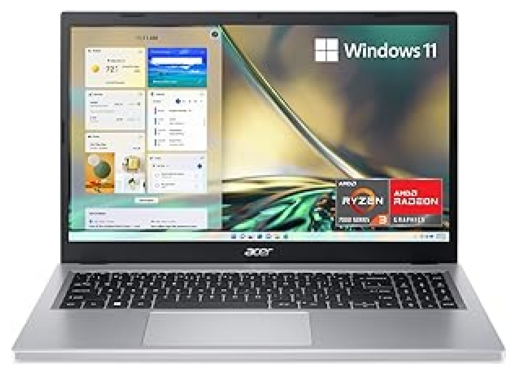

Image Index:  25
Predict:  this is a great megapixel camera.
True: i got this for 6 k. at this price point, i believe the tv provides decent quality.


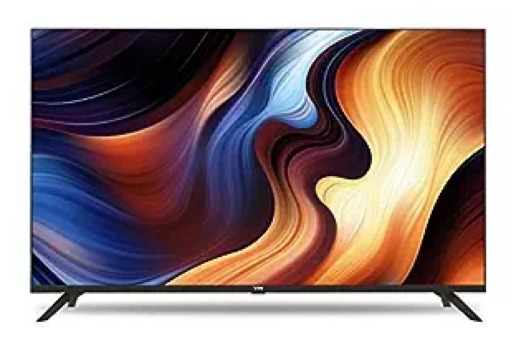

Image Index:  281
Predict:  i cant say enough about this backpack.
True: i cant speak for the durability of this backpack for longer than 4 months because i bought this backpack going


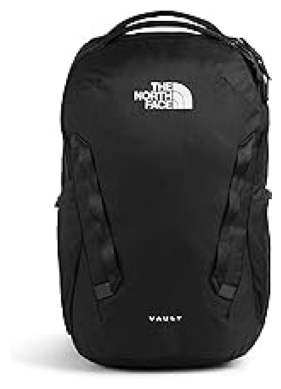

Image Index:  250
Predict:  this product is very easy to use and looks great on my sink.
True: i like everything about this product including shipping.


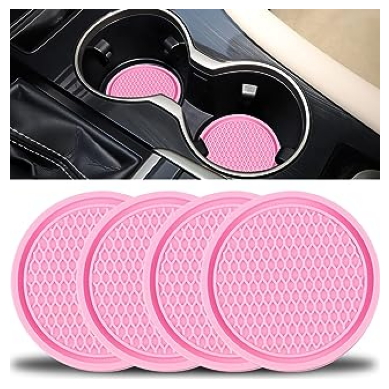

Image Index:  228
Predict:  greatest of all our patio set up.
True: finally chose this pair of outdoor chairs after i compared with other products. it came earlier than expected


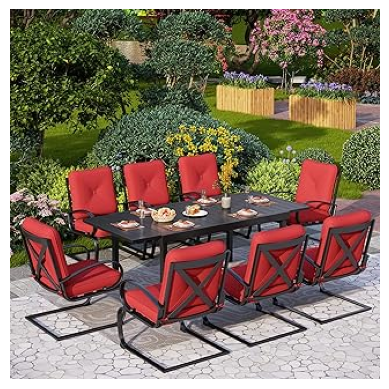

Image Index:  142
Predict:  reasons why we need to use it. i have been using this for
True: a lot of thought and care went into the packaging of this lemon zester!a sheath to


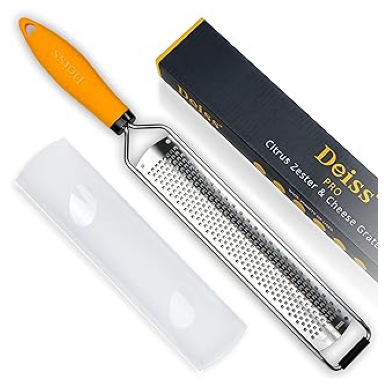

Image Index:  104
Predict:  its good quality and price is great.
True: if you have brain,its very easy to install and yes the plastic is good enough to hold your


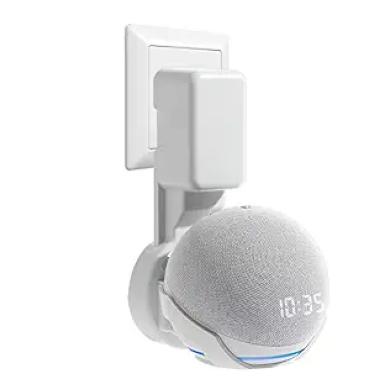

Image Index:  558
Predict:  perfectly designed and printed.
True: came with more than i needed, super cute not hard to remove off of hard surfaces if need


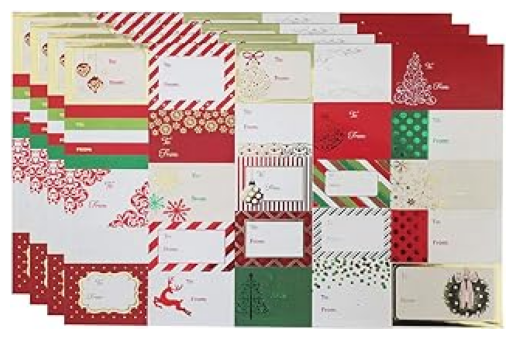

Image Index:  89
Predict:  i bought this for my son.
True: perfect for a 10 inch tablet both vertically and horizontally,it was the best phone holder,premium


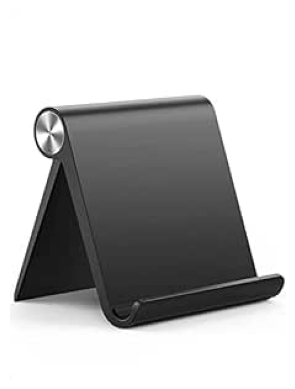

Image Index:  432
Predict:  i use this product extensively and highly recommend it to its owner. i am
True: lots of power


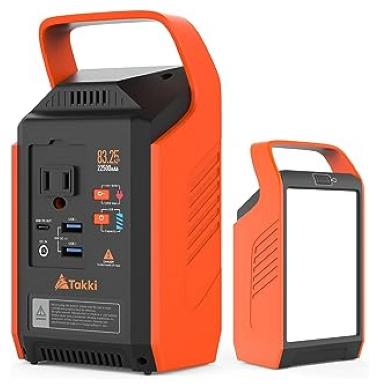

Image Index:  32
Predict:  nice product,good to use and light weight. i am using it for
True: good,httpsm.media-amazon.comimagesi41 d5 g0 vx76


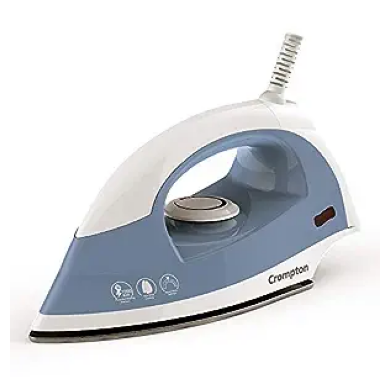

Image Index:  30
Predict:  had ordered this for my wife and i wanted to try it out.
True: had used ptron earphones earlier. so wanted to tried this one. and its good,new


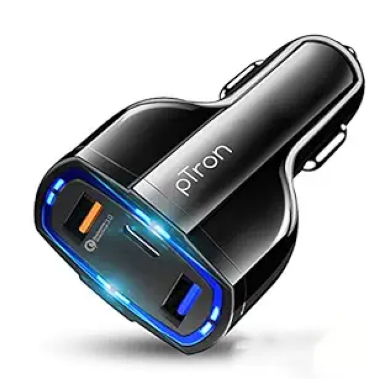

Image Index:  95
Predict:  this is a great tool for getting rid of crevices. i use
True: nice product, low noise and good suction power in price range, received damaged packet and without hose


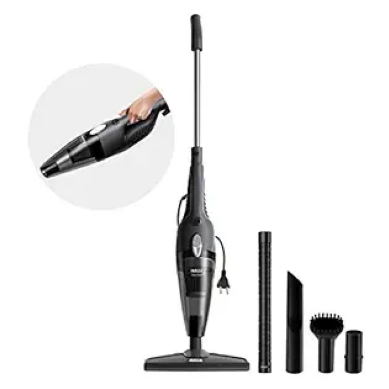

Image Index:  223
Predict:  it was very easy to assemble.
True: prosloving the sofa set. just installed yesterday. quality material and cushion covers.cons1.


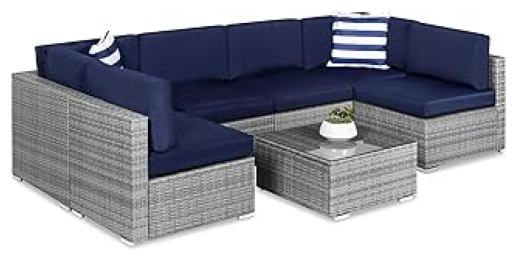

Image Index:  238
Predict:  it was a great product.i bought it for my son to use as
True: it was exactly as advertised.arrived on time, purchased for myself and also a few as gifts


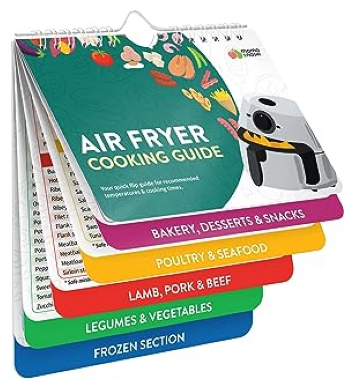

Image Index:  517
Predict:  great for the holidays!
True: perfect for your first aid kit!!


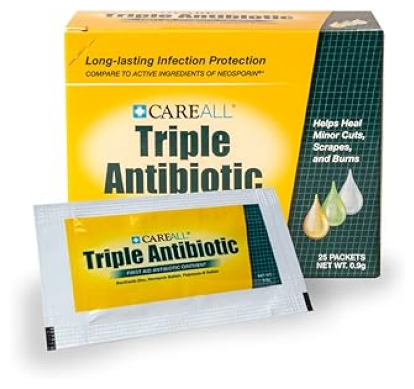

Image Index:  27
Predict:  this is a great product and i like it.
True: cord length shoul may be longer,the product quality is good.,very nice mai is


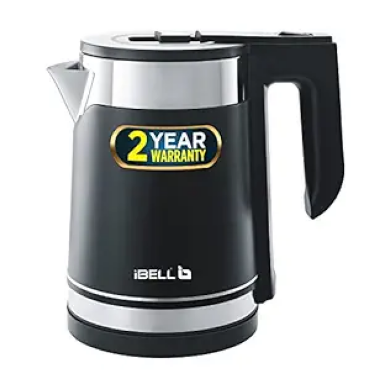

Image Index:  574
Predict:  this is a great product for your daily use.
True: the scent is very pleasant! it burns a long time.


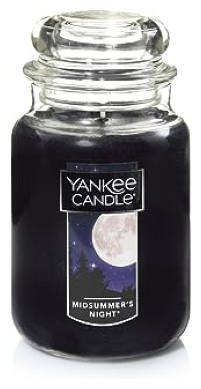

Image Index:  203
Predict:  great product.
True: what an amazing price for the amount of product i got in the barbie package! this is serving


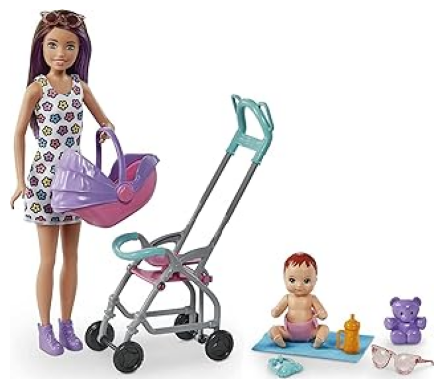

Image Index:  558
Predict:  perfectly packaged.
True: came with more than i needed, super cute not hard to remove off of hard surfaces if need


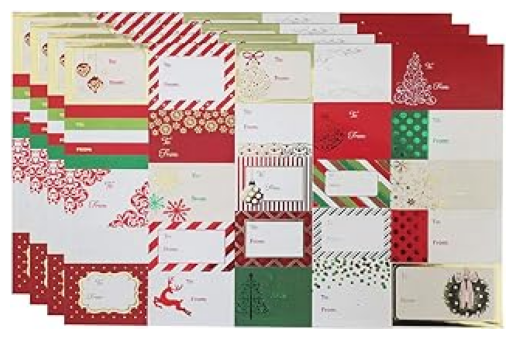

In [ ]:
import random

for i in range(20):
    rand_idx = random.randint(0, len(testset) - 1)
    img, true_text, _ = testset[rand_idx]


    img_tensor = image_processor(img, return_tensors="pt").pixel_values[0]
    text = generate_text(model, img_tensor)
    print("Image Index: ", rand_idx)
    print("Predict: ", text)
    print("True:", tokenizer.decode(true_text, skip_special_tokens=True))

    plt.imshow(img); plt.axis('off');plt.show()

### **Validation**

**Load Previous Model**

In [ ]:
# run = wandb.init()
# artifact = run.use_artifact('hungchiehwu/ConvNEXT-GPT2-amazon-name-v4/model-kaf5cqwr:v0', type='model')
# artifact_dir = artifact.download()

# model = ImageCaptioner(convNext_model, gpt_model, tokenizer, 0)
# checkpoint = torch.load(f"{artifact_dir}/model.ckpt")
# model.load_state_dict(checkpoint["state_dict"])

##### **Inference Comparison**

In [41]:
!wget --no-cache -q -O selected_images.zip https://github.com/littlehongman/Comp576-Group41-Image-Captioning/raw/main/selected_images.zip

!unzip -qq selected_images.zip

Predict:  boat wired on ear bluetooth headset with mic and microphone noise cancelling headphones


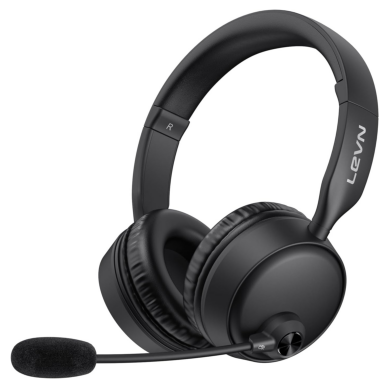

Predict:  kentagami 19 lint water purifier 1.


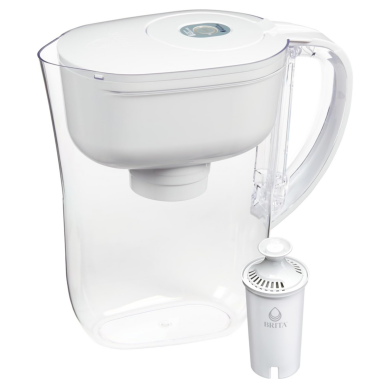

Predict:  hanes mens ecosmart long sleeve pullover t-shirt designs


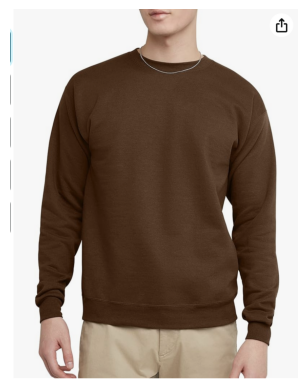

Predict:  ��五 hot water bottle clip set up for hiking and diving underwater with


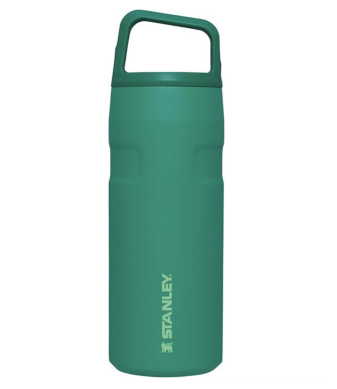

Predict:  riangshook backpack for women college students - usb charging ports USB port


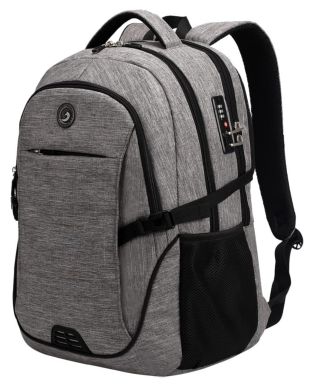

Predict:  anko bluetooth portable backpack flex nylon band with usb 3.0 w


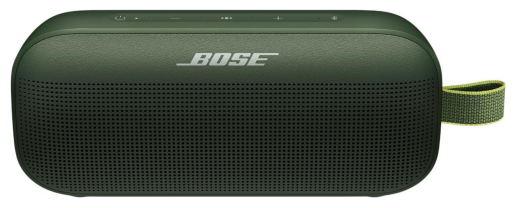

Predict:  f lime strips pickle juice clear polyurethane soap for use with


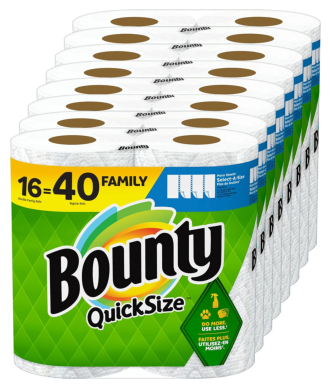

Predict:   grease powder slime mold oil spray bottle size 6 oz 1.


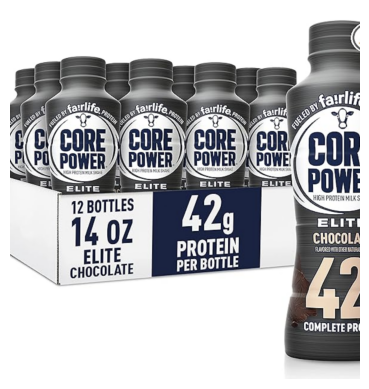

Predict:  camel contact cream for retinoids and iridescent eye drops -


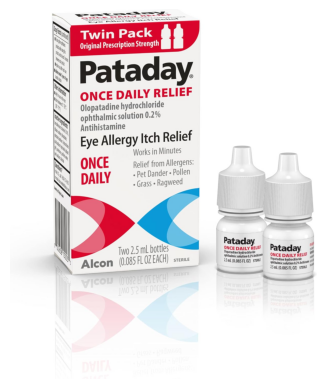

Predict:  microsoft xbox wireless controller astral purple dongle - new way to


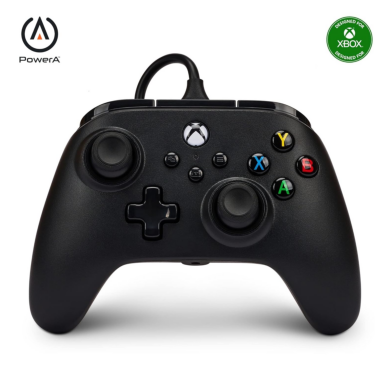

In [43]:
import os

image_dir = 'selected_images'

for filename in os.listdir(image_dir):

    if filename[-3:] in ['jpg', 'png'] or filename[-4:] in ['jpeg']:
        img = Image.open(os.path.join(image_dir, filename)).convert("RGB")


        img_tensor = image_processor(img, return_tensors="pt").pixel_values[0]
        text = generate_text(model, img_tensor)

        print("Predict: ", text)

        plt.imshow(img); plt.axis('off');plt.show()

 ##### **Calculate Metrics**

In [ ]:
from torchmetrics.text.rouge import ROUGEScore
from torchmetrics import BLEUScore
import evaluate
from tqdm import tqdm

def calculate_metrics(model, testset):
    model = model.to(device)

    #metrics
    total_rouge_scores = 0.0
    total_meteor_scores = 0.0
    total_bleu_scores = 0.0

    rouge = ROUGEScore()
    bleu = BLEUScore(n_gram=1)
    meteor = evaluate.load('meteor')

    for i in tqdm(range(len(testset))):
      img, reference, _ = testset[i]

      img_tensor = image_processor(img, return_tensors="pt").pixel_values[0].to(device)

      text = generate_text(model, img_tensor)
      reference = tokenizer.decode(reference, skip_special_tokens=True)

      total_rouge_scores += rouge(text, reference)['rougeL_fmeasure'].item()
      total_meteor_scores += meteor.compute(predictions=[text], references=[reference])['meteor']
      total_bleu_scores += bleu([text], [[reference]])

    print("\nRouge Score: {:.2f} Meteor Score: {:.2f} Bleu Score: {:.2f}".format(total_rouge_scores / len(testset) * 100, total_meteor_scores / len(testset) * 100, total_bleu_scores / len(testset) * 100))

In [ ]:
calculate_metrics(model, testset)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
100%|██████████| 599/599 [02:07<00:00,  4.71it/s]


Rouge Score: 18.66 Meteor Score: 15.49 Bleu Score: 12.14


### **Save Model**

In [ ]:
wandb.finish()